Title: Final Project for Stats and Machine Learning\
Date: Jan. 3, 2021\
Author: Edwin Lotero\
Summary: Classification Model using Random Forest Algorithm

## Introduction

This project will look at various factors that may be related to use of mental health services among the population. While causative factors require more complex analysis and study than I will conduct here, statistical models may be employed for identifying individuals in society that may be in need of mental health services  or may require in the future. This report will construct a predictive model for classifying these individuals by their various characteristics using a random forest classification scheme.

## Data Description
The data I analyzed in this report, file name PUF2019_100920, was generated from the results of the 2019 National Survey on Drug Use and Health (NSDUH) which was administered by the Substance Abuse and Mental Health Services Administration (SAMHSA). It is public access and available through the agency's public database website, https://www.datafiles.samhsa.gov/. The purpose of the survey is to college factors relating to the prevalence of substance use and mental health issues among the United States population, and is the 39th in its series. The data set is made up of 2,741 variables and 56,136 observations which include fields such as youth experiences, mental health and substance use history, demographic identifiers, and educational attainment. Each observation is unique.

## Data Source
The data source can be downloaded here for processing: https://www.datafiles.samhsa.gov/dataset/national-survey-drug-use-and-health-2019-nsduh-2019-ds0001

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from pathlib import Path

In [3]:
# load data set
raw_data = pd.read_csv('C:\\Users\\elote\\Repositories\\Statistics-and-Machine-Learning-Fall-2021\\data\\NSDUH_2015_2019.csv')
#raw_data = pd.read_csv('C:\\Users\\elote\\Repositories\\Statistics-and-Machine-Learning-Fall-2021\\data\\NSDUH_2019.txt', delim_whitespace=True)

C:\Users\elote\AppData\Local\Temp\ipykernel_29172\4250624786.py:2: DtypeWarning: Columns (2512) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('C:\\Users\\elote\\Repositories\\Statistics-and-Machine-Learning-Fall-2021\\data\\NSDUH_2015_2019.csv')


In [230]:
# Better:
from pathlib import Path
DATA_DIR = Path('C:\\Users\\elote\\Repositories\\Statistics-and-Machine-Learning-Fall-2021\\data\\')
raw_data = pd.read_csv(DATA_DIR / "NSDUH_2015_2019.csv")

C:\Users\elote\AppData\Local\Temp\ipykernel_2652\48493878.py:4: DtypeWarning: Columns (2512) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(DATA_DIR / "NSDUH_2015_2019.csv")


In [4]:
raw_data.shape

(282768, 2812)

Do we have a unique identifier?

In [10]:
# get # unique values for each column
unique_counts = raw_data.dropna().nunique()

# Identify columns where all values are unique
potential_identifiers = unique_counts[unique_counts == len(raw_data)]
print(potential_identifiers)

Series([], dtype: int64)


## Preprocessing

Being a large data set with a vast number of variables, it was necessary to narrow down to several of interest to the creation of a classification model. These are listed and defined below, and their values are taken from the data set codebook:

### Target variable
The outcome variable selected is AMHTXRC3: Received any mental health treatment within the past year
  * 1 = Yes
  * 2 = No 

### Predictor variables
The features selected are:
* illyr: ANY ILLICIT DRUG - PAST YEAR USE
  * 0 = Did not use in past year
  * 1 = Used in past year
* bngdrkmon: BINGE ALCOHOL USE PAST 30 DAYS
  * 0 = Never/No "Binge" alc use
  * 1 = "Binge" alcohol use
* hvydrkmon: HEAVY ALCOHOL USE PAST 30 DAYS
  * 0 = Never/No heavy alc use
  * 1 = Heavy alcohol use
* snysell: SOLD ILLEGAL DRUGS
  * 1 = 0 times
  * 2 = 1 or 2 times
  * 3 = 3 to 5 times
  * 4 = 6 to 9 times
  * 5 = 10 or more times
* snrlgsvc: AST 12 MOS, HOW MANY RELIG. SERVICES
  * 1 = 0 times
  * 2 = 1 to 2 times
  * 3 = 3 to 5 times
  * 4 = 6 to 24 times
  * 5 = 25 to 52 times
  * 6 = More than 52 times
* snrlgimp: MY RELIGIOUS BELIEFS ARE VERY IMPORTANT
  * 1 = Strongly Disagree
  * 2 = Disagree
  * 3 = Agree
  * 4 = Strongly Agree
* sexident: SEXUAL IDENTITY
  * 1 = Heterosexual, that is, straight.
  * 2 = Lesbian or Gay
  * 3 = Bisexual
* irsex: GENDER
  * 1 = Male
  * 2 = Female
* eduhighcat: EDUCATION CATEGORIES
  * 1 = Less high school
  * 2 = High school grad
  * 3 = Some coll/Assoc Dg
  * 4 = College graduate 
  * 5 = 12 to 17 year olds
* HEALTH2: OVERALL HEALTH
  * 1 = Excellent
  * 2 = Very Good
  * 3 = Good
  * 4 = Fair/Poor
* NEWRACE2: RACE/HISPANICITY
  * 1 = NonHisp White
  * 2 = NonHisp Black/Afr Am
  * 3 = NonHisp Native Am/AK Native
  * 4 = NonHisp Native HI/Other Pac Isl
  * 5 = NonHisp Asian 
  * 6 = NonHisp more than one race
* CATAG3: AGE CATEGORY
  * 1 = 12-17 Years Old
  * 2 = 18-25 Years Old.
  * 3 = 26-34 Years Old
  * 4 = 35-49 Years Old
  * 5 = 50 or Older
* wrkdpstyr: PAST 12 MONTHS, WORKED AT ANY JOB
  * 1 = Yes
  * 2 = No
* irwrkstat: EMPLOYMENT STATUS
  * 1 = Employed full time 
  * 2 = Employed part time
  * 3 = Unemployed
* income: TOTAL FAMILY INCOME
  * 1 = Less than $20,000
  * 2 = $20,000 - $49,999
  * 3 = $50,000 - $74,999
  * 4 = $75,000 or More
* POVERTY3: POVERTY LVL (% OF US CENSUS POVERTY THRESHOLD)
  * 1 = Living in Poverty
  * 2 = Income Up to 2X Fed Pov Thresh
  * 3 = Income More Than 2X Fed Pov Thresh
* medicare: COVERED BY MEDICARE
  * 1 = Yes
  * 2 = No
* caidchip: COVERED BY MEDICAID/CHIP
  * 1 = Yes
  * 2 = No
* champus: COV BY TRICARE, CHAMPUS, CHAMPVA, VA, MILITARY
  * 1 = Yes
  * 2 = No

Subset the raw data to narrow down to predictors and outcome variable:

In [12]:
columns_lower = [col.lower() for col in raw_data.columns]
raw_data.columns = columns_lower
print(raw_data.columns[0:20])

Index(['cigever', 'cigofrsm', 'cigwilyr', 'cigtry', 'cigyfu', 'cigmfu',
       'cigrec', 'cig30use', 'cg30est', 'cig30av', 'cig30br2', 'cig30tpe',
       'cig30men', 'cig30mln', 'cig30ro2', 'cigdlymo', 'cigage', 'cigdlyfu',
       'cigdlmfu', 'cig100lf'],
      dtype='object')


In [13]:
# select features
features_list = ['amhtxrc3', 'illyr', 'bngdrkmon', 'hvydrkmon', 'snysell', 'snrlgsvc', 'snrlgimp', 'sexident', 'irsex', 'eduhighcat', 'health2', 
'newrace2', 'catag3', 'wrkdpstyr', 'irwrkstat', 'income', 'poverty3', 'medicare', 'caidchip', 'champus']

# features_list = [col.lower() for col in predictor_list]
print(features_list)

['amhtxrc3', 'illyr', 'bngdrkmon', 'hvydrkmon', 'snysell', 'snrlgsvc', 'snrlgimp', 'sexident', 'irsex', 'eduhighcat', 'health2', 'newrace2', 'catag3', 'wrkdpstyr', 'irwrkstat', 'income', 'poverty3', 'medicare', 'caidchip', 'champus']


In [14]:
# select subset of raw data with predictors and outcome
df1 = raw_data[features_list].copy()

In [15]:
df2 = raw_data[features_list].copy()

In [18]:
df2['snrlgimp'].nunique()

10

In [32]:
raw_data.iloc[:, 0:20].head(10)

,cigever,cigofrsm,cigwilyr,cigtry,cigyfu,cigmfu,cigrec,cig30use,cg30est,cig30av,cig30br2,cig30tpe,cig30men,cig30mln,cig30ro2,cigdlymo,cigage,cigdlyfu,cigdlmfu,cig100lf
0,1,99,99,16,2014,1,2,93,93,93,9993,93,93,93,93,2,999,9999,99,2
1,1,99,99,15,9999,99,3,93,93,93,9993,93,93,93,93,1,16,9999,99,1
2,2,99,99,991,9991,91,91,91,91,91,9991,91,91,91,91,91,991,9991,91,91
3,2,3,4,991,9991,91,91,91,91,91,9991,91,91,91,91,91,991,9991,91,91
4,1,99,99,17,9999,99,1,22,99,3,112,1,2,1,2,1,18,9999,99,1
5,1,99,99,21,9999,99,2,93,93,93,9993,93,93,93,93,2,999,9999,99,1
6,1,99,99,17,9999,99,4,93,93,93,9993,93,93,93,93,2,999,9999,99,2
7,2,4,4,991,9991,91,91,91,91,91,9991,91,91,91,91,91,991,9991,91,91
8,2,4,4,991,9991,91,91,91,91,91,9991,91,91,91,91,91,991,9991,91,91
9,2,4,4,991,9991,91,91,91,91,91,9991,91,91,91,91,91,991,9991,91,91


In [19]:
# find largest number of unique values in a column
biggest = 0
cols = []

for col in raw_data.columns:
    count = raw_data[col].nunique()
    if count > biggest:
        biggest = count
        
print(biggest)

278734


In [25]:
df_unique = raw_data.nunique().reset_index()
df_unique.columns = ['Column', 'UniqueValues']
df_unique

,Column,UniqueValues
0,cigever,2
1,cigofrsm,9
2,cigwilyr,10
3,cigtry,65
4,cigyfu,14
...,...,...
2807,opmedyr2,2
2808,alopmedyr,2
2809,kratflg,2
2810,kratyr,2


In [33]:
df_unique['UniqueValues'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

count      2812.000000
mean        116.279161
std        5259.150939
min           2.000000
10%           2.000000
20%           2.000000
30%           3.000000
40%           6.000000
50%           7.000000
60%           8.000000
70%           9.000000
80%          10.000000
90%          21.900000
99%         127.890000
max      278734.000000
Name: UniqueValues, dtype: float64

BMI is a continous variable with high cardinality. Is there a categorical variable that is similar?

In [37]:
df_unique.loc[df_unique['UniqueValues']>50]

,Column,UniqueValues
3,cigtry,65
10,cig30br2,127
16,cigage,74
21,smklsstry,82
28,cigartry,83
...,...,...
2480,cabingage,91
2571,wrkdhrswk2,67
2580,wrknjbwks,57
2581,wrklastyr2,51


In [29]:
df_unique['UniqueValues'].unique()

array([     2,      9,     10,     65,     14,     19,     12,     36,
           13,    127,      8,      7,     74,      5,     82,     15,
            4,     83,     93,     77,    285,    203,     39,     66,
           38,     87,    325,    204,     11,    137,      3,     64,
           32,     91,     50,     25,     31,     63,     72,     33,
            6,    240,    129,     84,     49,     70,    128,     37,
           55,     62,    119,     46,     18,     61,     52,     30,
           73,    154,     99,     35,     67,     21,     16,     43,
           27,     23,     22,     53,     29,     20,     17,    287,
          324,    126,    131,    130,    158,     41,     28,     34,
           92,     90,     79,     78,     89,     76,     58,     60,
           51,     59,     56,     57,     80,     69,    185,    298,
           81,    147,     24,     45,    125,    620,     97,     88,
           95,    105,     47,     44,    225,    102,     98,   5637,
      

In [27]:
df_unique.loc[df_unique['UniqueValues']==278734]

,Column,UniqueValues
2674,analwt_c,278734


In [21]:
raw_data.dropna().shape

(0, 2812)

In [17]:
df2['snrlgimp'].value_counts()

snrlgimp
3     71465
99    68261
4     66765
1     41368
2     30544
97     2350
94     1918
98       65
85       30
89        2
Name: count, dtype: int64

Here we do an initial inspection of the working dataframe to notice its structure:

In [201]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282768 entries, 0 to 282767
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   amhtxrc3    213140 non-null  float64
 1   illyr       282768 non-null  int64  
 2   bngdrkmon   282768 non-null  int64  
 3   hvydrkmon   282768 non-null  int64  
 4   snysell     282768 non-null  int64  
 5   snrlgsvc    282768 non-null  int64  
 6   snrlgimp    282768 non-null  int64  
 7   sexident    282768 non-null  int64  
 8   irsex       282768 non-null  int64  
 9   eduhighcat  282768 non-null  int64  
 10  health2     282713 non-null  float64
 11  newrace2    282768 non-null  int64  
 12  catag3      282768 non-null  int64  
 13  wrkdpstyr   282768 non-null  int64  
 14  irwrkstat   282768 non-null  int64  
 15  income      282768 non-null  int64  
 16  poverty3    280578 non-null  float64
 17  medicare    282768 non-null  int64  
 18  caidchip    282768 non-null  int64  
 19  ch

Some of the features have multiple levels of category according to the codebook. This includes levels that are not useful to the analysis. The following is one example, followed by the dropping of those levels in the various features:

In [202]:
print(df1.describe(include='all'))

            amhtxrc3          illyr      bngdrkmon      hvydrkmon  \
count  213140.000000  282768.000000  282768.000000  282768.000000   
mean        1.840790       0.235522       0.249017       0.062008   
std         0.365873       0.424325       0.432444       0.241171   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         2.000000       0.000000       0.000000       0.000000   
75%         2.000000       0.000000       0.000000       0.000000   
max         2.000000       1.000000       1.000000       1.000000   

             snysell       snrlgsvc       snrlgimp       sexident  \
count  282768.000000  282768.000000  282768.000000  282768.000000   
mean       25.024200      26.566963      27.439774      26.128498   
std        42.104799      41.645870      41.962421      42.641689   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.0000

In [203]:
df1['amhtxrc3'].value_counts()

amhtxrc3
2.0    179206
1.0     33934
Name: count, dtype: int64

In [204]:
# check distribution of bad values
df1['snysell'].value_counts()

snysell
1     209113
99     68261
2       2110
5       1339
3        619
97       568
4        331
94       310
98        62
85        53
89         2
Name: count, dtype: int64

In [205]:
# drop bad data from columns
df1 = df1[df1['snysell'].isin([1, 2, 3, 4, 5])]
df1 = df1[df1['snrlgsvc'].isin([1, 2, 3, 4, 5, 6])]
df1 = df1[df1['snrlgimp'].isin([1, 2, 3, 4])]
df1 = df1[df1['sexident'].isin([1, 2, 3])]
df1 = df1[df1['health2'].isin([1, 2, 3, 4])]
df1 = df1[df1['irwrkstat'].isin([1, 2, 3])]
df1 = df1[df1['medicare'].isin([1, 2])]
df1 = df1[df1['caidchip'].isin([1, 2])]
df1 = df1[df1['champus'].isin([1, 2])]

We can do another inspection here. It is noticeable that the number of rows has decreased since we have removed bad data, but it also seems like we have null values. We will attend to this next.

In [206]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152206 entries, 1 to 282764
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   amhtxrc3    151930 non-null  float64
 1   illyr       152206 non-null  int64  
 2   bngdrkmon   152206 non-null  int64  
 3   hvydrkmon   152206 non-null  int64  
 4   snysell     152206 non-null  int64  
 5   snrlgsvc    152206 non-null  int64  
 6   snrlgimp    152206 non-null  int64  
 7   sexident    152206 non-null  int64  
 8   irsex       152206 non-null  int64  
 9   eduhighcat  152206 non-null  int64  
 10  health2     152206 non-null  float64
 11  newrace2    152206 non-null  int64  
 12  catag3      152206 non-null  int64  
 13  wrkdpstyr   152206 non-null  int64  
 14  irwrkstat   152206 non-null  int64  
 15  income      152206 non-null  int64  
 16  poverty3    151154 non-null  float64
 17  medicare    152206 non-null  int64  
 18  caidchip    152206 non-null  int64  
 19  champus

### Check for null values

Two columns contain null values, or NAs, in the data: AMHTXRC3 and POVERTY3. As they represent a small percentage of the total, we will drop these from the data and observe that the NAs are now gone:

In [207]:
# check for null values
pd.DataFrame(df1.isnull().sum())

,0
amhtxrc3,276
illyr,0
bngdrkmon,0
hvydrkmon,0
snysell,0
snrlgsvc,0
snrlgimp,0
sexident,0
irsex,0
eduhighcat,0


In [208]:
# drop null values
df1 = df1.dropna()

In [209]:
pd.DataFrame(df1.isnull().sum())

,0
amhtxrc3,0
illyr,0
bngdrkmon,0
hvydrkmon,0
snysell,0
snrlgsvc,0
snrlgimp,0
sexident,0
irsex,0
eduhighcat,0


## Build the model

### Decision Trees
Decision trees work similarly to how its namesake is structured. We begin with one main branch and then split into sub-branches at each feature in the decision tree. 

### Random Forest Classifier
The random forest classifier operates with an ensemble of decision trees, each sampling a number of features present in a set of predictor variables. Each decision tree then calculates a prediction for the outcome variable and the prediction with the greatest number becomes the model's main prediction. 

The random forest classifier must take the dependent variable as a binary outcome, 0's and 1's; hence, we will recode the values appropriately. Then we prepare the data set for our model by splitting it into a features component and outcome component (X and y). 

In [210]:
df1['amhtxrc3'].replace({2.0: 0, 1.0: 1}, inplace=True)

C:\Users\elote\AppData\Local\Temp\ipykernel_2652\4076239563.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['amhtxrc3'].replace({2.0: 0, 1.0: 1}, inplace=True)


In [211]:
# Split into X and y
X = df1.drop('amhtxrc3', axis=1)
y = df1.pop('amhtxrc3')

Encode the variables as 'category' datatype since they are categorical, not numerical, for proper interpretation by the model:

In [212]:
# Encode categorical data for predictors as 'category' dtype
col_names = list(X)

for col in col_names:
    X[col] = X[col].astype('category', copy=False)

In [213]:
# verify types
X.dtypes

illyr         category
bngdrkmon     category
hvydrkmon     category
snysell       category
snrlgsvc      category
snrlgimp      category
sexident      category
irsex         category
eduhighcat    category
health2       category
newrace2      category
catag3        category
wrkdpstyr     category
irwrkstat     category
income        category
poverty3      category
medicare      category
caidchip      category
champus       category
dtype: object

We will create our train/test split using a 80/20 ratio and saving the seed state for reproducibility:

In [214]:
# Create train/test split
seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

The following code will process the depended variables through a one hot encoding function, splitting up the various levels in each feature to create binary measures. This will ensure proper handling and interpretability for our random forest model. The constructor below takes in both numerical and categorical data types in order to properly do the one hot encoding; however, as our model includes only categorical features, they will all pass into the encoder:

In [216]:
# Identify categorical features
enc_feat = X_train.columns[X_train.dtypes == 'category'].tolist() 

Here we define the random forest classifier along with its hyperparameters. 

We will make use of the pipeline feature of sklearn to perform the needed encoding, transformation, and classification of our train/test split data. It is a convenient way to reuse code in a concise manner for when multiple model fittings will be performed. Here we do that and also generate our test predictions for assessing the model performance:

In [227]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define column transformer
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), enc_feat), 
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
)

# Define random forest classifier object
classifier = RandomForestClassifier(
    min_samples_leaf=50,
    n_estimators=150,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=seed,
    max_features='sqrt'
)

# Create pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Fit the pipeline
pipe.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = pipe.predict(X_test)


KeyboardInterrupt: 

## Evaluate the model

### Accuracy
Accuracy is defined by the sum of true positives and true negatives divided by the total number of predictions. That is, it quantifies how well the model correctly classifies the test samples. The accuracy_score() function will calculate this value for us:

In [220]:
acc_score = (accuracy_score(y_test, y_pred)) * 100
print("The accuracy of the model is ", acc_score, "%")

The accuracy of the model is  85.07864969954048 %


#### Predict Probabilities and ROC AUC Scores
The predict_proba() function allows us to predict the probability of label 1 for our target variable in the train and test dataframes. In turn, these values will be fed into the roc_auc_score() function to plot the Receiver Operating Characteristic (ROC) score and ROC Area Under Curve (ROC AUC) scores from test and train prediction scores:

In [221]:
# Predict probabilities
prob_train = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_preds = pipe.predict(X_train)

ROC AUC is produced by calulating the rate of true positives versus the rate of false positives at any particular threshold (the x-axis). Threshold means the value at which a prediction is interpreted to be true or not (1 or 0). The closer the ROC AUC scores are to 1.0, the more predictive power the model has:

In [222]:
# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, prob_train)
test_roc_auc = roc_auc_score(y_test, probs)

print('Train ROC AUC Score: ', train_roc_auc)
print('Test ROC AUC  Score: ', test_roc_auc)

Train ROC AUC Score:  0.7510952101726052
Test ROC AUC  Score:  0.7316990899262972


Next, we plot the ROC against a baseline curve as a visual aid to compare the mode's performance. As a review, the recall of the model, or sensitivity, is defined as number of true positives divided by the sum of true positives and false negatives. Precision, on the other hand, is defined as the number of true positives divided by the sum of true positives and false positives. These values are fed into the mod_eval() function below to generate the curve.

The baseline curve shown in blue represents a random classifier that cannot tell the difference between the two classes of the outcome variable and is shown as reference. We can see that the model is closer to 1.0 than baseline, (about 0.73 for the test data), indicating a modest degree of predictive power: 

Recall Baseline: 0.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.0 Test: 0.86 Train: 0.83
Roc Baseline: 0.5 Test: 0.73 Train: 0.75


c:\Users\elote\miniconda3\envs\datasciml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


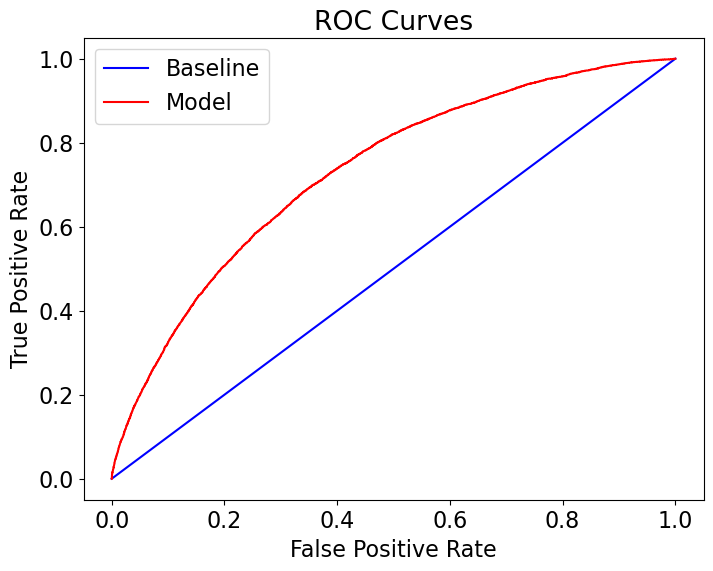

In [223]:
# plot the ROC AUC

def mod_eval(y_pred, probs, train_preds, prob_train):
    """
    Evaluates the model by printing recall, precision, and ROC AUC scores for both test and train data.
    Also plots the ROC curves.
    """
    # Calculate baseline based on the majority class
    baseline_class = y_test.mode()[0]
    baseline_preds = [baseline_class] * len(y_test)
    baseline = {}
    baseline['recall'] = recall_score(y_test, baseline_preds)
    baseline['precision'] = precision_score(y_test, baseline_preds)
    baseline['roc'] = 0.5  # Baseline ROC for random classifier
    
    # Calculate metrics for the model
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    # Calculate metrics for the training data
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_preds)
    train_results['precision'] = precision_score(y_train, train_preds)
    train_results['roc'] = roc_auc_score(y_train, prob_train)
    
    # Print the metrics
    for metric in ['recall', 'precision', 'roc']:  
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
     
    # Calculate false positive rates and true positive rates for ROC curves
    base_fpr, base_tpr, _ = roc_curve(y_test, [baseline_class] * len(y_test))
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    
    # Plot the ROC curves
    plt.figure(figsize=(8, 6))
    plt.rcParams['font.size'] = 16
    
    plt.plot(base_fpr, base_tpr, 'b', label='Baseline')
    plt.plot(model_fpr, model_tpr, 'r', label='Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.show()

mod_eval(y_pred, probs, train_preds, prob_train)

### Confusion Matrix
A Confusion Matrix provides us with another metric to evaluate the quality of the output of our random forest classifier and makes use of some of the values we have already mentioned and calculated above. Diagonal elements represent correctly classified predictions (true negatives and positives) while the others are incorrecly classified (false negatives and positives). Here we can see a numerical representation of where the loss of performance of our model lies: a high number of false negatives (1558) and few true negatives (1):

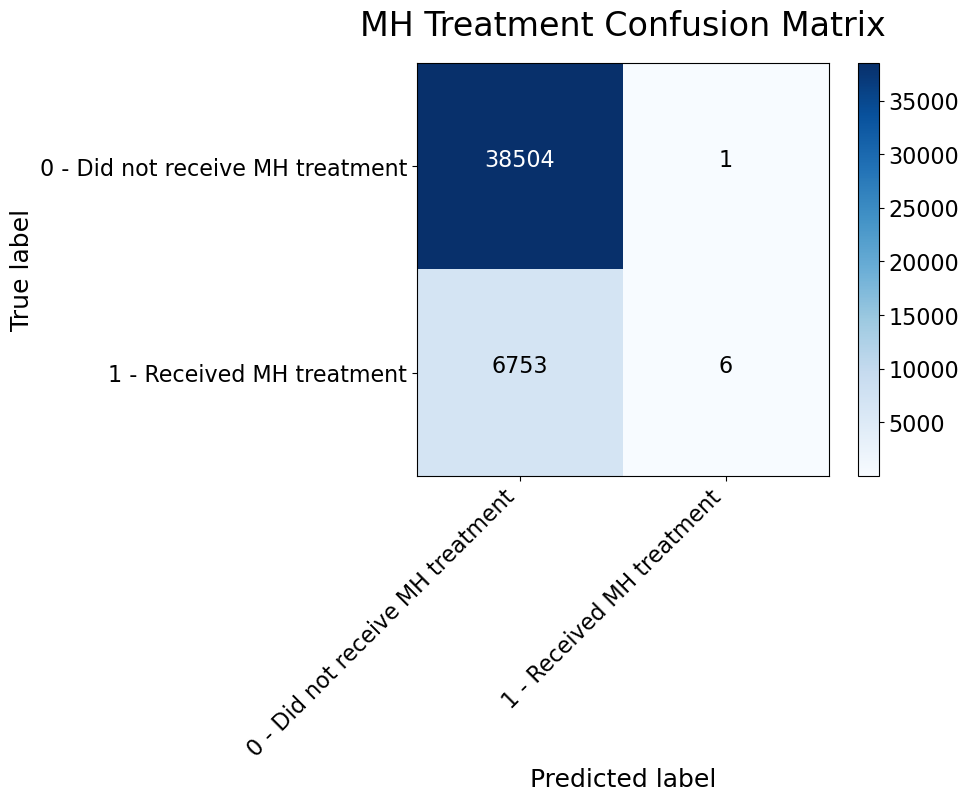

In [224]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.
    
    Parameters:
    - cm: Confusion matrix
    - classes: List of class names
    - normalize: Whether to normalize the confusion matrix
    - title: Title of the plot
    - cmap: Color map
    """
    # If normalize is True, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24, pad=20)
    plt.colorbar()

    # Add tick marks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    # Add text annotations to each cell
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                size=16)

    # Improve layout
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    
    return plt

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    cm=cm,
    classes=['0 - Did not receive MH treatment', '1 - Received MH treatment'],
    title='MH Treatment Confusion Matrix'
)
plt.show()

### Feature Importance
Using the results of the classification model, we can assess the importance of the different features in the data set. The number of features as calculated here are more numerous than the number of predictor variables that were selected at the start of the analysis. This is due to the pipe function above which properly transformed the categorical data for each level as they were being inputed into the model algorithm. 

We can count the number of features and visualize the relative importance of each feature using the import_feat_ module of the random forest classifier:

The enc_bind function will encode and bind our expanded training data set into a dataframe for use in calculating the relative importance of each feature level:

We can now create and display an ordered rank of relative importance for each feature level numerically and graphically:

In [225]:
print(pipe.named_steps.keys())

dict_keys(['preprocessor', 'classifier'])


Feature: newrace2_1                          Importance: 0.13557113663147974
Feature: irsex_1                             Importance: 0.12058847407381934
Feature: irsex_2                             Importance: 0.10256499360419738
Feature: illyr_0                             Importance: 0.059362280652653816
Feature: illyr_1                             Importance: 0.05932349121834815
Feature: sexident_1                          Importance: 0.0506219045030217
Feature: health2_1.0                         Importance: 0.0380069609532688
Feature: newrace2_2                          Importance: 0.03550741733586421
Feature: sexident_3                          Importance: 0.031927108753554714
Feature: newrace2_7                          Importance: 0.02772990015870627
Feature: eduhighcat_4                        Importance: 0.02699351768373576
Feature: health2_4.0                         Importance: 0.023719758279416005
Feature: health2_3.0                         Importance: 0.0207058817566904

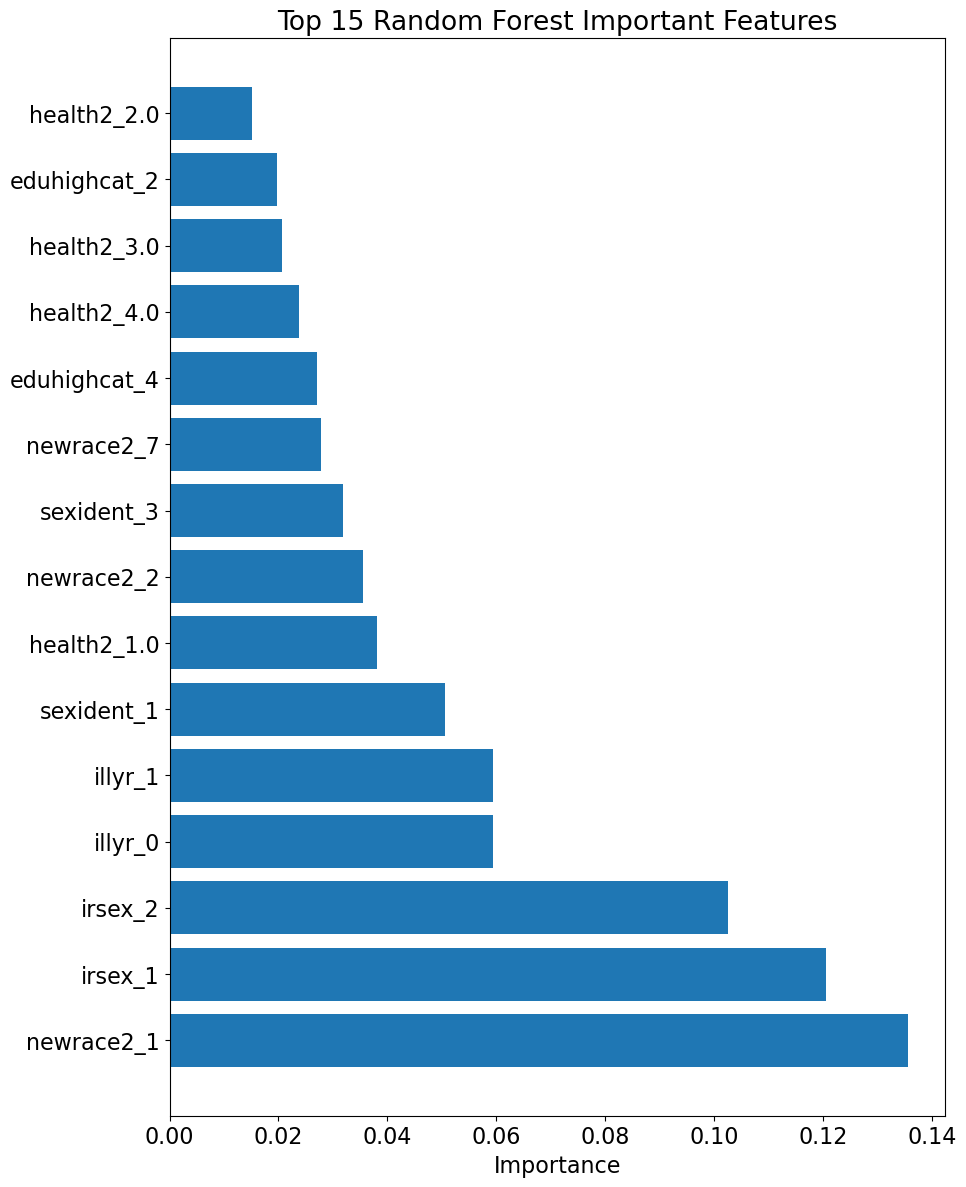

In [226]:
# Extract the OneHotEncoder using the correct name
ohe = pipe.named_steps['preprocessor'].transformers_[0][1]

# Get the encoded feature names
encoded_features = ohe.get_feature_names_out(enc_feat)

# Identify passthrough features by excluding encoded features from all features
passthrough_features = [col for col in X_train.columns if col not in enc_feat]

# Combine encoded and passthrough feature names
all_feature_names = list(encoded_features) + passthrough_features

# Extract feature importances from the classifier within the pipeline
classifier = pipe.named_steps['classifier']
import_feat = list(zip(all_feature_names, classifier.feature_importances_))

# Sort the feature importances by most important first
import_feat_ranked = sorted(import_feat, key=lambda x: x[1], reverse=True)

# Print out the features and their importances
for feature, importance in import_feat_ranked:
    print(f'Feature: {feature:35} Importance: {importance}')

# Plot of Top 15 Feature Importance
top_15 = [i[0] for i in import_feat_ranked[:15]]
x_axis = [i[1] for i in import_feat_ranked[:15]]

plt.figure(figsize=(10, 14))
plt.barh(top_15, x_axis)   # horizontal barplot
plt.title('Top 15 Random Forest Important Features')
plt.xlabel('Importance', fontdict={'fontsize': 16})
plt.show()


According to the results, the 10 most important features which contribute best to the predictive power of the model are:
* NEWRACE2_1: non-hispanic white
* irsex_1: Male
* irsex_2: Female
* sexident_1: Heterosexual
* illyr_1: used illicit drugs in the past year
* sexident_3: Bisexual
* illyr_0: did not use illicit drugs in the past year
* HEALTH2_1.0: Excellent health
* HEALTH2_4.0: Fair/poor health
* eduhighcat_4: College graduates

## Conclusion and Next Steps

### Feature Selection/Engineering
The important features identification process could be taken a step further to rebuild the model using the top 15 features and measure its effect on the accuracy of the new model's performance to compare it to the old one.

### Hyperparameter Tuning
The next step here would be to run a series of models while setting the parameters for the random forest classifier at random, each time recording the model performance by calculating the ROC AUC and accuracies as above. In addition, hyperparameter tuning helps to mitigate the tradeoff between bias and variance so as to minimize error and maximize goodness-of-fit. 